In [ ]:
# Imports and global settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

sns.set(style="whitegrid", context="notebook")
random_state = 42


## Load Iris dataset

In [ ]:
# Load dataset
data = datasets.load_iris()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

print('Features:', feature_names)
print('Target names:', target_names)
print('X shape:', X.shape, 'y shape:', y.shape)


Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']
X shape: (150, 4) y shape: (150,)


## Train / Test split (stratified)

In [ ]:
# train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=random_state
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (105, 4) Test shape: (45, 4)


## 1) Manual Least Squares (single feature)
- We'll fit a simple least-squares line mapping one feature to the numeric target (0,1,2). We'll show the fitted line and a scatter of actual classes. Output (classification report & accuracy) shown separately.

=== Manual Least Squares (1 feature) ===
              precision    recall  f1-score   support

      setosa       0.79      0.73      0.76        15
  versicolor       0.42      0.67      0.51        15
   virginica       0.57      0.27      0.36        15

    accuracy                           0.56        45
   macro avg       0.59      0.56      0.55        45
weighted avg       0.59      0.56      0.55        45

Accuracy: 0.5556



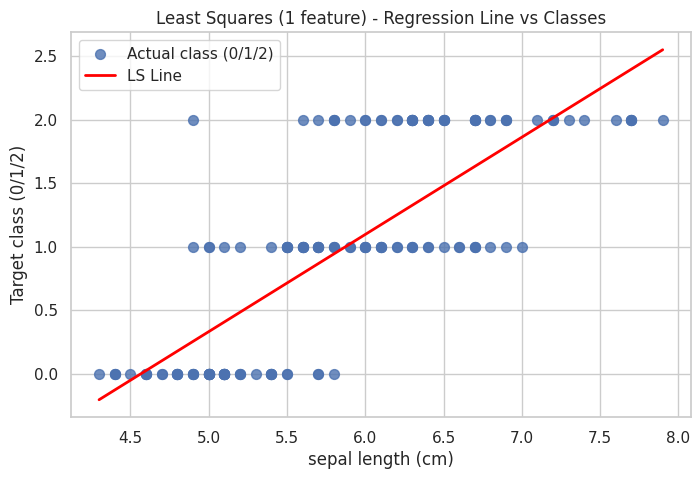

In [ ]:
feat_idx = 0  # use sepal length (first feature)
X_single_train = X_train[:, feat_idx]
X_single_test = X_test[:, feat_idx]

# compute slope m and intercept c on TRAINING data (simple linear regression)
X_mean = np.mean(X_single_train)
y_mean = np.mean(y_train.astype(float))
m = np.sum((X_single_train - X_mean) * (y_train - y_mean)) / np.sum((X_single_train - X_mean)**2)
c = y_mean - m * X_mean

# continuous predictions -> round to nearest class and clip
y_pred_lr_cont = m * X_single_test + c
y_pred_lr = np.rint(y_pred_lr_cont).astype(int)
y_pred_lr = np.clip(y_pred_lr, 0, 2)

acc_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr, target_names=target_names)

print('=== Manual Least Squares (1 feature) ===')
print(report_lr)
print(f'Accuracy: {acc_lr:.4f}\n')

# Plot regression (whole dataset with LS line)
X_single_all = X[:, feat_idx]
y_all = y
y_pred_all = m * X_single_all + c
plt.figure(figsize=(8,5))
plt.scatter(X_single_all, y_all, label='Actual class (0/1/2)', s=50, alpha=0.8)
order = np.argsort(X_single_all)
plt.plot(X_single_all[order], y_pred_all[order], color='red', linewidth=2, label='LS Line')
plt.xlabel(feature_names[feat_idx])
plt.ylabel('Target class (0/1/2)')
plt.title('Least Squares (1 feature) - Regression Line vs Classes')
plt.legend()
plt.show()


## 2) Perceptron (full features)

In [ ]:
# Perceptron (full features)
scaler_full = StandardScaler()
X_train_full = scaler_full.fit_transform(X_train)
X_test_full = scaler_full.transform(X_test)

perceptron_full = Perceptron(random_state=random_state, max_iter=2000, tol=1e-4)
perceptron_full.fit(X_train_full, y_train)
y_pred_perc = perceptron_full.predict(X_test_full)
acc_perc = accuracy_score(y_test, y_pred_perc)
report_perc = classification_report(y_test, y_pred_perc, target_names=target_names)

print('=== Perceptron (full features) ===')
print(report_perc)
print(f'Accuracy: {acc_perc:.4f}\n')


=== Perceptron (full features) ===
              precision    recall  f1-score   support

      setosa       0.88      1.00      0.94        15
  versicolor       0.65      0.87      0.74        15
   virginica       1.00      0.53      0.70        15

    accuracy                           0.80        45
   macro avg       0.84      0.80      0.79        45
weighted avg       0.84      0.80      0.79        45

Accuracy: 0.8000



## 3) SVM (full features) + GridSearchCV

In [ ]:
# SVM (full features) + GridSearchCV
svm = SVC(kernel='rbf', probability=True, random_state=random_state)
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1, 1]}
grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_full, y_train)
best_svm = grid.best_estimator_
y_pred_svm = best_svm.predict(X_test_full)
acc_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm, target_names=target_names)

print('=== SVM (full features) - GridSearch best params ===')
print('Best params:', grid.best_params_)
print(report_svm)
print(f'Accuracy: {acc_svm:.4f}\n')


=== SVM (full features) - GridSearch best params ===
Best params: {'C': 1, 'gamma': 0.1}
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45

Accuracy: 0.9111



## 4) PCA -> Perceptron (top-2 PCs) + PCA 2D & 3D visualizations

PCA(2) explained variance ratio: [0.72962445 0.22850762] sum: 0.9581320720000166
PCA(3) explained variance ratios: [0.72962445 0.22850762 0.03668922]


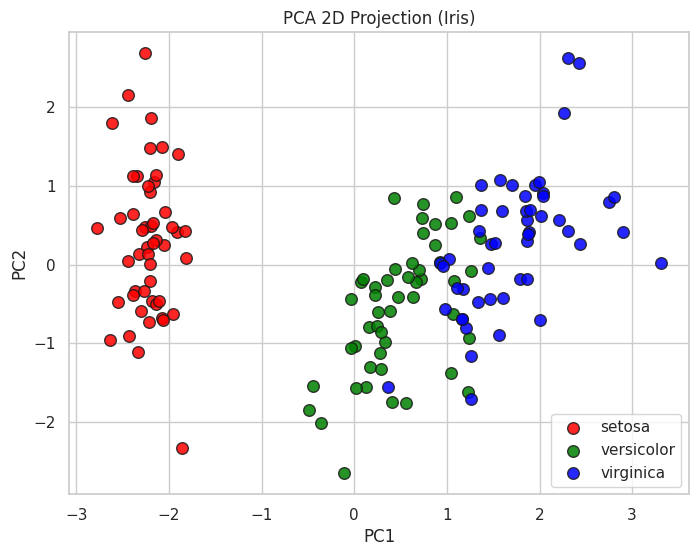

In [ ]:
# PCA visualizations
scaler_for_pca = StandardScaler()
X_scaled = scaler_for_pca.fit_transform(X)  # whole dataset scaled for PCA

pca2 = PCA(n_components=2, random_state=random_state)
X_pca_2d = pca2.fit_transform(X_scaled)
explained_ratio_2 = pca2.explained_variance_ratio_
print('PCA(2) explained variance ratio:', explained_ratio_2, 'sum:', explained_ratio_2.sum())

pca3 = PCA(n_components=3, random_state=random_state)
X_pca_3d = pca3.fit_transform(X_scaled)
print('PCA(3) explained variance ratios:', pca3.explained_variance_ratio_)

# 2D PCA scatter (Iris has 3 classes)
colors = ['red', 'green', 'blue']
plt.figure(figsize=(8,6))
for color, i, label in zip(colors, [0,1,2], target_names):
    plt.scatter(X_pca_2d[y==i,0], X_pca_2d[y==i,1], color=color, label=label, s=70, alpha=0.85, edgecolors='k')
plt.title('PCA 2D Projection (Iris)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

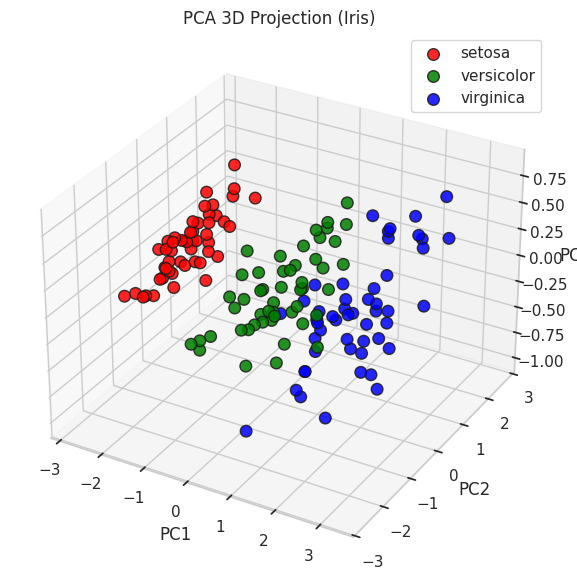

In [ ]:
# 3D PCA scatter
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
for color, i, label in zip(colors, [0,1,2], target_names):
    ax.scatter(X_pca_3d[y==i,0], X_pca_3d[y==i,1], X_pca_3d[y==i,2], color=color, label=label, s=70, alpha=0.85, edgecolors='k')
ax.set_title('PCA 3D Projection (Iris)')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.legend()
plt.show()


## 5) Perceptron on PCA(2) features

In [ ]:
# Train Perceptron on top-2 PCA components (split with same stratify)
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca_2d, y, test_size=0.30, stratify=y, random_state=random_state
)
# Optional scaling of PC space (not strictly necessary)
scaler_pca = StandardScaler()
X_pca_train_s = scaler_pca.fit_transform(X_pca_train)
X_pca_test_s = scaler_pca.transform(X_pca_test)

perc_pca = Perceptron(random_state=random_state, max_iter=2000, tol=1e-4)
perc_pca.fit(X_pca_train_s, y_pca_train)
y_pred_pca = perc_pca.predict(X_pca_test_s)
acc_pca = accuracy_score(y_pca_test, y_pred_pca)
report_pca = classification_report(y_pca_test, y_pred_pca, target_names=target_names)

print('=== Perceptron on PCA(2) features ===')
print(report_pca)
print(f'Accuracy: {acc_pca:.4f}\n')


=== Perceptron on PCA(2) features ===
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.74      0.93      0.82        15
   virginica       0.91      0.67      0.77        15

    accuracy                           0.87        45
   macro avg       0.88      0.87      0.86        45
weighted avg       0.88      0.87      0.86        45

Accuracy: 0.8667



## 6) Logistic Regression (full features)

In [ ]:
# Logistic Regression baseline (full features)
logreg = LogisticRegression(max_iter=5000, random_state=random_state)
logreg.fit(X_train_full, y_train)
y_pred_log = logreg.predict(X_test_full)
acc_log = accuracy_score(y_test, y_pred_log)
report_log = classification_report(y_test, y_pred_log, target_names=target_names)
print('=== Logistic Regression (full features) ===')
print(report_log)
print(f'Accuracy: {acc_log:.4f}\n')


=== Logistic Regression (full features) ===
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45

Accuracy: 0.9111



## 7) Decision boundary visualizations (first two original features)
- Perceptron and SVM decision boundaries, support vectors and margins (visualization similar to original PDF).

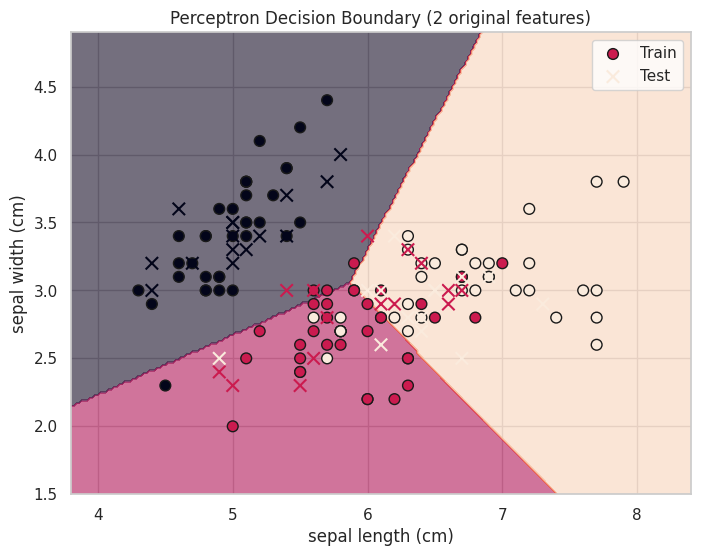

In [ ]:
# Decision boundary visualizations (2-feature projection = first two original features)
vis_idx = [0,1]
X_vis = X[:, vis_idx]
X_vis_train, X_vis_test, y_vis_train, y_vis_test = train_test_split(
    X_vis, y, test_size=0.30, stratify=y, random_state=random_state
)
scaler_vis = StandardScaler()
X_vis_train_s = scaler_vis.fit_transform(X_vis_train)
X_vis_test_s = scaler_vis.transform(X_vis_test)

# Perceptron for visualization
perc_vis = Perceptron(random_state=random_state, max_iter=2000, tol=1e-4)
perc_vis.fit(X_vis_train_s, y_vis_train)

# SVM linear for visualization
svm_vis = SVC(kernel='linear', C=1.0, random_state=random_state)
svm_vis.fit(X_vis_train_s, y_vis_train)

# Mesh grid using exact min/max values step 0.02 (careful with large ranges)
x_min, x_max = X_vis[:,0].min(), X_vis[:,0].max()
y_min, y_max = X_vis[:,1].min(), X_vis[:,1].max()
xx, yy = np.meshgrid(np.arange(x_min - 0.5, x_max + 0.5, 0.02),
                     np.arange(y_min - 0.5, y_max + 0.5, 0.02))
mesh_grid = np.c_[xx.ravel(), yy.ravel()]
grid_s = scaler_vis.transform(mesh_grid)

# Perceptron decision map (multi-class)
Zp = perc_vis.predict(grid_s).reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Zp, alpha=0.6)
plt.scatter(X_vis_train[:,0], X_vis_train[:,1], c=y_vis_train, edgecolors='k', s=60, label='Train')
plt.scatter(X_vis_test[:,0], X_vis_test[:,1], c=y_vis_test, marker='x', s=80, label='Test')
plt.title('Perceptron Decision Boundary (2 original features)')
plt.xlabel(feature_names[vis_idx[0]])
plt.ylabel(feature_names[vis_idx[1]])
plt.legend()
plt.show()



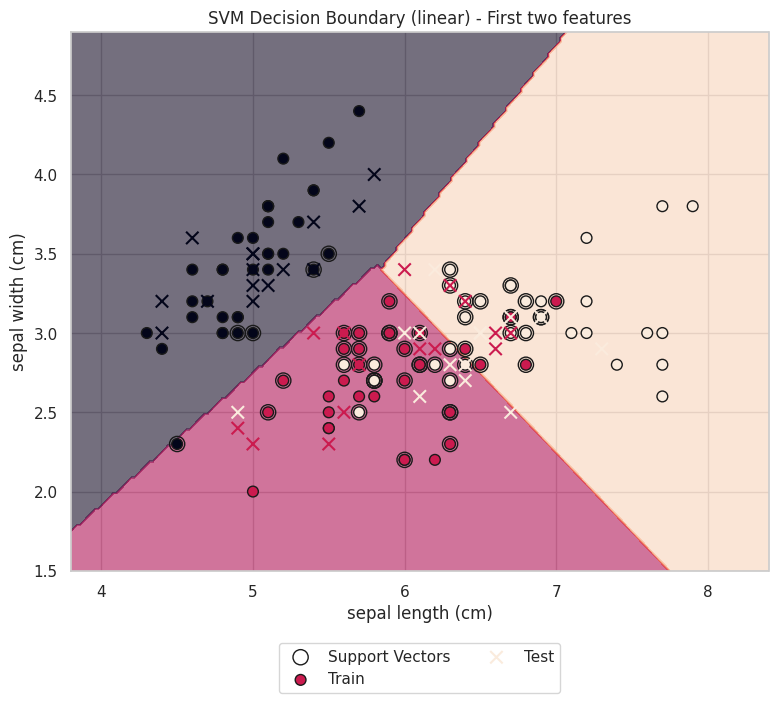

In [ ]:
# SVM decision boundary + margins + support vectors (multi-class via one-vs-rest decision function)
# For multiclass linear SVM we will plot predicted class regions
Zs_class = svm_vis.predict(grid_s).reshape(xx.shape)
plt.figure(figsize=(9,7))
plt.contourf(xx, yy, Zs_class, alpha=0.6)

# support vectors (for multiclass, SVC stores them for each binary problem; plot the ones from estimator)
sv_orig = scaler_vis.inverse_transform(svm_vis.support_vectors_)
plt.scatter(sv_orig[:,0], sv_orig[:,1], s=120, facecolors='none', edgecolors='k', label='Support Vectors')
plt.scatter(X_vis_train[:,0], X_vis_train[:,1], c=y_vis_train, edgecolors='k', s=60, label='Train')
plt.scatter(X_vis_test[:,0], X_vis_test[:,1], c=y_vis_test, marker='x', s=80, label='Test')
plt.title('SVM Decision Boundary (linear) - First two features')
plt.xlabel(feature_names[vis_idx[0]])
plt.ylabel(feature_names[vis_idx[1]])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
plt.show()

## 8) Final accuracy comparison table & bar chart


=== Accuracy Summary ===
       Model  Accuracy
LeastSquares  0.555556
  Perceptron  0.800000
         SVM  0.911111
         PCA  0.866667
    Logistic  0.911111


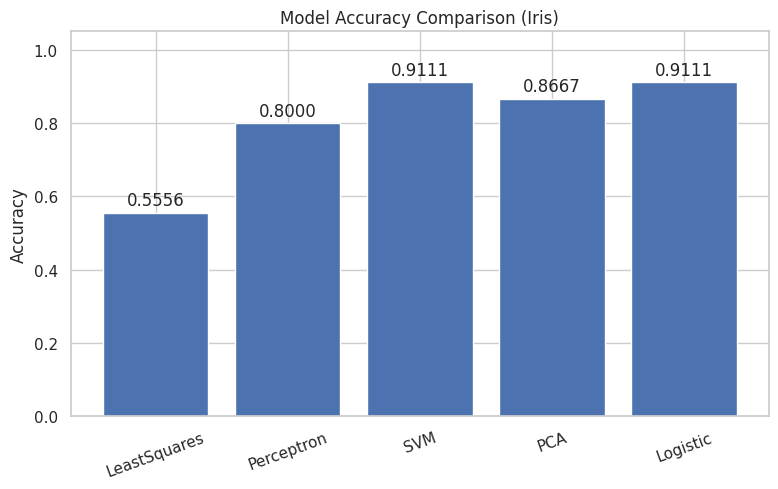

In [ ]:
models = ['LeastSquares', 'Perceptron', 'SVM', 'PCA', 'Logistic']
accuracies = [acc_lr, acc_perc, acc_svm, acc_pca, acc_log]

summary_df = pd.DataFrame({'Model': models, 'Accuracy': accuracies})
print('\n=== Accuracy Summary ===')
print(summary_df.to_string(index=False))

plt.figure(figsize=(9,5))
bars = plt.bar(summary_df['Model'], summary_df['Accuracy'])
plt.ylim(0,1.05)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (Iris)')
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.02, f"{acc:.4f}", ha='center')
plt.xticks(rotation=20)
plt.show()
